In [1]:
import torch
import torch.nn as nn
import cv2
from torchvision import transforms
from PIL import Image
import joblib

In [ ]:
# Niclas sätt att importera yolov5
import yolov5
model_path = "./saved_models/fish_model_yolov5_23-12-20.pt"
fish_model = yolov5.load(model_path)
fish_model.conf = 0.14

: 

#### Fish Model

In [22]:
yolo_path = "C:/Users/emmel/Desktop/testning av yolov5/yolov5"
model_path = "./saved_models/fish_model_yolov5_23-12-20.pt"

fish_model = torch.hub.load(yolo_path, 'custom', path=model_path, source='local')
fish_model.conf = 0.10

YOLOv5  2023-10-18 Python-3.10.6 torch-2.1.1+cpu CPU



Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7246518 parameters, 0 gradients
Adding AutoShape... 


#### Sick Fish Model
Exempelkod för att ladda den modell vi väl använder:

In [23]:
sick_model = joblib.load("./saved_models/my_random_forest.joblib")  

#### Testbild

In [2]:
image_path = "./dataset/test_img/Healthy_fishies/Red Mullet/00142.png"
original_image = cv2.imread(image_path)
image = Image.fromarray(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

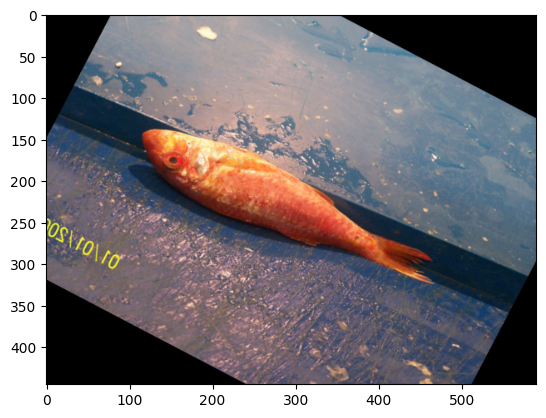

In [5]:
import matplotlib.pyplot as plt

plt.imshow(image)

In [15]:
original_image = Image.open(image_path)
crop_coordinates = (100, 100, 400, 350)
cropped_image = original_image.crop(crop_coordinates)

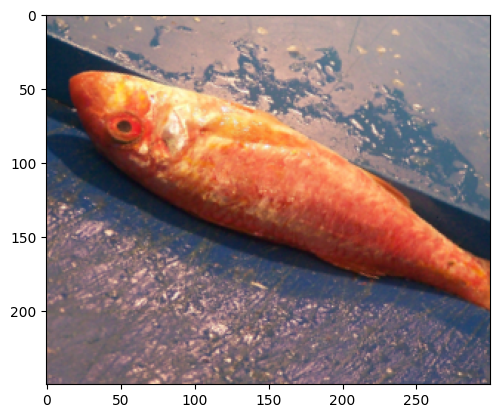

In [16]:
plt.imshow(cropped_image)

### Lets go!

In [ ]:
yolo_result = fish_model(image)
yolo_preds = yolo_result.pandas().xyxy[0]

if len(yolo_preds) > 0:
    print(f"Fish detected")
    
for _, yolo_pred in yolo_preds.iterrows():
    bbox = yolo_pred[['xmin', 'ymin', 'xmax', 'ymax']].astype(int).tolist()
    roi = original_image[bbox[1]:bbox[3], bbox[0]:bbox[2]]  

    cv2.imread(roi)

    # Preprocessing för sick model  

    second_model_output = sick_model.predict([........])

    print(f"Prediction for ROI: Class {second_model_output[0]}")

else:
    print(f"No fish detected")
